In [213]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [214]:
trainDatasetPath = 'dataset/train.csv'
valDatasetPath = 'dataset/val.csv'
testDatasetPath = 'dataset/test.csv'

tooMuchNullValueFeatureThreshold = 500  # 若某个特征缺失的样本数量超过该值，认定为坏特征
tooMuchNullValueSampleThreshold = 5  # 若某个样本缺失的特征超过该值，认定为坏样本
tooMuchPossibleValueFeatureThreshold = 300  # 如果特征的可能的值多于该数，认定为没有参考性
tooLessPossibleValueFeatureThreshold = 2  # 如果特征的可能的值少于该数，认定为没有参考性

In [215]:
unusedFeatureList = []
tooMuchNullValueFeatureList = []

tooMuchPossibleValueFeatureList = []
tooLessPossibleValueFeatureList = []

tooMuchNullValueSampleList = []


In [216]:
trainDatasetDF = pd.read_csv(filepath_or_buffer=trainDatasetPath, header=0, index_col=None)
valDatasetDF = pd.read_csv(filepath_or_buffer=valDatasetPath, header=0, index_col=0)
testDatasetDF = pd.read_csv(filepath_or_buffer=testDatasetPath, header=0, index_col=0)

# originTrainDatasetDF = pd.read_csv(filepath_or_buffer=trainDatasetPath, header=0, index_col=None)
# 查看数据集大小
print(trainDatasetPath, trainDatasetDF.shape)
print(valDatasetPath, valDatasetDF.shape)
print(testDatasetPath, testDatasetDF.shape)

dataset/train.csv (79786, 54)
dataset/val.csv (2836, 54)
dataset/test.csv (2836, 53)


In [217]:
def computeLabelDistributeDict(datasetDF):
    labelDistributeDict = datasetDF['grav'].value_counts().to_dict()
    return labelDistributeDict

def plotLabelDistribute(distributeDict, pltTitle='标签分布'):
    plt.figure(figsize=(6,3))
    plt.title(pltTitle)
    plt.xlabel('标签名称')
    plt.ylabel('标签数量')
    plt.grid()
    plt.xticks(labels=['Unharmed','Killed','Hospitalized','Slightly'], ticks=[1,2,3,4])
    plt.bar(x=distributeDict.keys(), height=distributeDict.values())
    plt.show()

trainLabelDistribute {1: 33264, 4: 31905, 3: 12537, 2: 2080}
valLabelDistribute {1: 745, 4: 724, 2: 713, 3: 654}


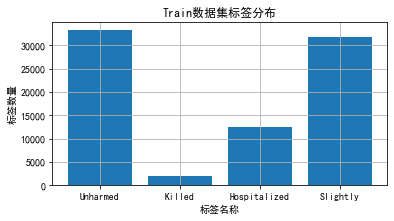

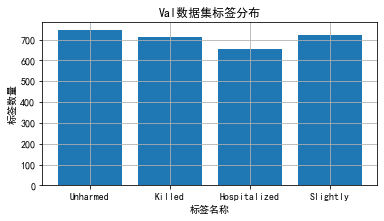

In [218]:
trainLabelDistribute = computeLabelDistributeDict(trainDatasetDF)
print("trainLabelDistribute", trainLabelDistribute)
valLabelDistribute = computeLabelDistributeDict(valDatasetDF)
print("valLabelDistribute", valLabelDistribute)
plotLabelDistribute(trainLabelDistribute, 'Train数据集标签分布')
plotLabelDistribute(valLabelDistribute, 'Val数据集标签分布')

In [219]:
def countAllNullValue(datasetDF):
    nullAmount = datasetDF.isnull().sum().sum()
    return nullAmount

In [220]:
trainDatasetNulls = countAllNullValue(trainDatasetDF)
print("trainDataset 的空值数量", trainDatasetNulls)
valDatasetNulls = countAllNullValue(valDatasetDF)
print("valDataset 的空值数量", valDatasetNulls)
testDatasetNulls = countAllNullValue(testDatasetDF)
print("testDataset 的空值数量", testDatasetNulls)

trainDataset 的空值数量 361556
valDataset 的空值数量 13081
testDataset 的空值数量 13126


In [221]:
def computeFeatureNullValue(datasetDF):
    featureNullDict = datasetDF.isnull().sum().sort_values(ascending=False).to_dict()
    return featureNullDict

def showFeatureNullValue(nullSortedDict, tops=20):
    plt.figure(figsize=(15,3))
    plt.grid()
    plt.xlabel("特征名称")
    plt.ylabel("特征缺失样本数量")
    plt.yscale('log')
    plt.title("缺失样本数量最多的Top%d特征 柱状图"%tops)
    plt.bar(x=list(nullSortedDict.keys())[0:tops], height=list(nullSortedDict.values())[0:tops])
    plt.show()

In [222]:
trainDatasetFeatureNullDict = computeFeatureNullValue(trainDatasetDF)
valDatasetFeatureNullDict = computeFeatureNullValue(valDatasetDF)
testDatasetFeatureNullDict = computeFeatureNullValue(testDatasetDF)


tooMuchNullValueFeatureList.extend(key for key in trainDatasetFeatureNullDict if trainDatasetFeatureNullDict[key] > tooMuchNullValueFeatureThreshold)
print(tooMuchNullValueFeatureList)

['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr']


In [223]:
trainDatasetDF.drop(columns=tooMuchNullValueFeatureList, inplace=True, errors='ignore')
valDatasetDF.drop(columns=tooMuchNullValueFeatureList, inplace=True, errors='ignore')
testDatasetDF.drop(columns=tooMuchNullValueFeatureList, inplace=True, errors='ignore')
unusedFeatureList.extend(tooMuchNullValueFeatureList)  # 将这些缺失样本过多的特征作为不会使用到的特征

In [224]:
def computeSampleNullValue(datasetDF):
    sampleNullDict = datasetDF.T.isnull().sum().sort_values(ascending=False).to_dict()
    return sampleNullDict

In [225]:
tooMuchNullValueSampleList = []
trainDatasetSampleNullDict = computeSampleNullValue(trainDatasetDF)
tooMuchNullValueSampleList.extend(key for key in trainDatasetSampleNullDict if trainDatasetSampleNullDict[key] > tooMuchNullValueSampleThreshold)


In [226]:
trainDatasetDF.drop(index=tooMuchNullValueSampleList, inplace=True, errors='ignore')
print("删除后trainDataset的shape : ", trainDatasetDF.shape)
print('trainDataset的空值数量',  countAllNullValue(trainDatasetDF))

删除后trainDataset的shape :  (79623, 41)
trainDataset的空值数量 264


In [227]:
def recordFeaturePossibleValueDict(datasetDF):
    featureAllPossibleValueDict = {}
    for featureName in datasetDF:
        oneFeaturePossibleValueCountDict = datasetDF[featureName].value_counts().to_dict()
        featureAllPossibleValueDict[featureName] = oneFeaturePossibleValueCountDict
    return featureAllPossibleValueDict

def countFeaturePossibleValueDict(datasetDF):
    featurePossiblesValueAmountDict = {}
    for featureName in datasetDF:
        oneFeaturePossibleValueCountDict = datasetDF[featureName].value_counts().to_dict()
        featurePossiblesValueAmountDict[featureName] = len(oneFeaturePossibleValueCountDict)
    return featurePossiblesValueAmountDict

def showFeaturePossibleValueCount(possiblesValueAmountDict):
    plt.figure(figsize=(25,3))
    plt.grid()
    plt.xlabel("特征名称")
    plt.ylabel("特征可能值数量(对数显式)")
    plt.yscale('log')
    plt.title("特征可能值统计 柱状图")
    plt.bar(x=list(possiblesValueAmountDict.keys()), height=list(possiblesValueAmountDict.values()))
    plt.show()

def showFeaturePossibleValueRecord(possiblesValueRecordDict, subplotCols=5):
    subFigNumbers = len(possiblesValueRecordDict)
    subplotRows = (subFigNumbers-1)//subplotCols + 1
    print('subplotRows : ', subplotRows)
    plt.figure(figsize=(25,30))
    for idx, subDictKey in enumerate(possiblesValueRecordDict):
        subDict = possiblesValueRecordDict[subDictKey]
        plt.subplot(subplotRows,subplotCols, idx+1)
        plt.title(subDictKey)
        plt.xlabel(subDictKey+'的可能值')
        plt.ylabel('可能值个数')
        plt.grid()
        plt.bar(x = list(subDict.keys()), height=list(subDict.values()))

In [228]:
featurePossibleValueCountDict = countFeaturePossibleValueDict(trainDatasetDF)
print(featurePossibleValueCountDict)

{'Num_Acc': 48304, 'jour': 31, 'mois': 12, 'an': 1, 'hrmn': 1347, 'lum': 5, 'dep': 107, 'com': 10018, 'agg': 2, 'int': 9, 'atm': 10, 'col': 8, 'lat': 46055, 'long': 46428, 'catr': 8, 'prof': 4, 'plan': 4, 'surf': 9, 'infra': 10, 'situ': 7, 'id_vehicule': 65846, 'num_veh': 27, 'place': 10, 'catu': 3, 'grav': 4, 'sexe': 2, 'an_nais': 103, 'trajet': 8, 'secu1': 11, 'secu2': 11, 'secu3': 10, 'locp': 11, 'actp': 13, 'etatp': 4, 'senc': 5, 'catv': 31, 'obs': 19, 'obsm': 8, 'choc': 11, 'manv': 28, 'motor': 8}


In [229]:
tooMuchPossibleValueFeatureList = [feature for feature in featurePossibleValueCountDict if featurePossibleValueCountDict[feature] > tooMuchPossibleValueFeatureThreshold]
tooLessPossibleValueFeatureList = [feature for feature in featurePossibleValueCountDict if featurePossibleValueCountDict[feature] < tooLessPossibleValueFeatureThreshold]

print("tooMuchValueFeatureList : ", tooMuchPossibleValueFeatureList)
print("tooLessValueFeatureList : ", tooLessPossibleValueFeatureList)

tooMuchValueFeatureList :  ['Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule']
tooLessValueFeatureList :  ['an']


In [230]:
unusedFeatureList.extend(tooMuchPossibleValueFeatureList)
unusedFeatureList.extend(tooLessPossibleValueFeatureList)
trainDatasetDF.drop(columns=tooMuchPossibleValueFeatureList, inplace=True)
trainDatasetDF.drop(columns=tooLessPossibleValueFeatureList, inplace=True)
valDatasetDF.drop(columns=tooMuchPossibleValueFeatureList, inplace=True)
valDatasetDF.drop(columns=tooLessPossibleValueFeatureList, inplace=True)
print("valDatasetDF.shape", valDatasetDF.shape)
testDatasetDF.drop(columns=tooMuchPossibleValueFeatureList, inplace=True)
testDatasetDF.drop(columns=tooLessPossibleValueFeatureList, inplace=True)
print("testDatasetDF.shape", testDatasetDF.shape)  # test少了grav列

valDatasetDF.shape (2836, 34)
testDatasetDF.shape (2836, 33)


In [231]:
manualLowVarianceFeatureList = ['obs', 'secu3', 'catv', 'infra', 'situ']
unusedFeatureList.extend(manualLowVarianceFeatureList)
print(manualLowVarianceFeatureList)
print(unusedFeatureList)

['obs', 'secu3', 'catv', 'infra', 'situ']
['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr', 'Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an', 'obs', 'secu3', 'catv', 'infra', 'situ']


In [232]:
trainDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('trainDatasetDF.shape', trainDatasetDF.shape)
valDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('valDatasetDF.shape', valDatasetDF.shape)
testDatasetDF.drop(columns=manualLowVarianceFeatureList, inplace=True, errors='ignore')
print('testDatasetDF.shape', testDatasetDF.shape)

trainDatasetDF.shape (79623, 29)
valDatasetDF.shape (2836, 29)
testDatasetDF.shape (2836, 28)


In [233]:
experienceDropFeatureList = ['dep', 'num_veh']
trainDatasetDF.drop(columns=experienceDropFeatureList, inplace=True, errors='ignore')
valDatasetDF.drop(columns=experienceDropFeatureList, inplace=True, errors='ignore')
testDatasetDF.drop(columns=experienceDropFeatureList, inplace=True, errors='ignore')
unusedFeatureList.extend(experienceDropFeatureList)

In [234]:
def getFeatureValueModeDict(datasetDF):
    modeDict = datasetDF.mode().T.to_dict()[0]
    return modeDict

def imputeFeatureValueByMode(datasetDF, datasetModeDict):
    for feature in datasetDF:
        tempImputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=datasetModeDict[feature])
        datasetDF[feature] = tempImputer.fit_transform(datasetDF[feature].values.reshape(-1,1))

In [235]:
trainFeatureValueModeDict = getFeatureValueModeDict(trainDatasetDF)
print(trainFeatureValueModeDict)
print(type(trainFeatureValueModeDict))

{'jour': 18.0, 'mois': 7.0, 'lum': 1.0, 'agg': 2.0, 'int': 1.0, 'atm': 1.0, 'col': 3.0, 'catr': 4.0, 'prof': 1.0, 'plan': 1.0, 'surf': 1.0, 'place': 1, 'catu': 1, 'grav': 1, 'sexe': 1, 'an_nais': 2000, 'trajet': 5, 'secu1': 1, 'secu2': 0, 'locp': 0, 'actp': '0', 'etatp': -1, 'senc': 1, 'obsm': 2, 'choc': 1, 'manv': 1, 'motor': 1}
<class 'dict'>


In [236]:
imputeFeatureValueByMode(trainDatasetDF, trainFeatureValueModeDict)
imputeFeatureValueByMode(valDatasetDF, trainFeatureValueModeDict)
imputeFeatureValueByMode(testDatasetDF, trainFeatureValueModeDict)

In [237]:
def applyLabelEncoderToDatasetDF(trainDF, valDF, testDF):
    objectFeature = trainDatasetDF.select_dtypes(include=['object']).columns.to_list()
    for feature in objectFeature:
        tempLabelEncoder = LabelEncoder()
        trainDF[feature] = tempLabelEncoder.fit_transform(trainDF[feature].to_list())
        valDF[feature] = tempLabelEncoder.transform(valDF[feature].to_list())
        testDF[feature] = tempLabelEncoder.transform(testDF[feature].to_list())

In [238]:
# 对三个数据集的object类型feature使用相同的LabelEncoder
print("object类型的features : ", trainDatasetDF.select_dtypes(include=['object']).columns.to_list())
print('----------Before Label Encoder----------')
print('trainDatasetDF   : ', trainDatasetDF['actp'].to_list()[0:10])
print('valDatasetDF     : ', valDatasetDF['actp'].to_list()[0:10])
print('testDatasetDF    : ', testDatasetDF['actp'].to_list()[0:10])
applyLabelEncoderToDatasetDF(trainDatasetDF, valDatasetDF, testDatasetDF)
print('----------After Label Encoder----------')
print('trainDatasetDF   : ', trainDatasetDF['actp'].to_list()[0:10])
print('valDatasetDF     : ', valDatasetDF['actp'].to_list()[0:10])
print('testDatasetDF    : ', testDatasetDF['actp'].to_list()[0:10])

object类型的features :  ['actp']
----------Before Label Encoder----------
trainDatasetDF   :  ['-1', '-1', '0', '0', '0', '0', '0', '0', '0', '0']
valDatasetDF     :  ['0', '3', '0', '0', '0', '0', '0', '0', '0', '0']
testDatasetDF    :  ['0', '5', '-1', '0', '0', '0', '0', '0', '-1', '-1']
----------After Label Encoder----------
trainDatasetDF   :  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
valDatasetDF     :  [1, 4, 1, 1, 1, 1, 1, 1, 1, 1]
testDatasetDF    :  [1, 6, 0, 1, 1, 1, 1, 1, 0, 0]


In [239]:
print(unusedFeatureList)


['lartpc', 'larrout', 'occutc', 'v2', 'v1', 'pr1', 'pr', 'circ', 'voie', 'vma', 'vosp', 'nbv', 'adr', 'Num_Acc', 'hrmn', 'com', 'lat', 'long', 'id_vehicule', 'an', 'obs', 'secu3', 'catv', 'infra', 'situ', 'dep', 'num_veh']


In [240]:
trainLabelDistributeDict = computeLabelDistributeDict(trainDatasetDF)
print(trainLabelDistributeDict)

{1: 33205, 4: 31839, 3: 12505, 2: 2074}


In [241]:
def getSampledDatasetDF(datasetDF):
    labelDistributeDict = computeLabelDistributeDict(datasetDF)
    maxLabelValue = max(labelDistributeDict, key=labelDistributeDict.get)
    maxLabelValueAmount = labelDistributeDict[maxLabelValue]//10

    sampledDatasetDF = datasetDF.groupby('grav').get_group(maxLabelValue).sample(maxLabelValueAmount, replace=True, random_state=42)

    for labelValue in labelDistributeDict:
        if labelValue != maxLabelValue:
            tempValueDF = datasetDF.groupby('grav').get_group(labelValue).sample(maxLabelValueAmount, replace=True, random_state=42)
            sampledDatasetDF = pd.concat([sampledDatasetDF, tempValueDF], axis=0)
    return sampledDatasetDF

In [242]:
print("(Before sample)TrainDatasetDF.shape : ", trainDatasetDF.shape)
sampledTrainDatasetDF = getSampledDatasetDF(trainDatasetDF)
print("(After sample)TrainDatasetDF.shape : ", sampledTrainDatasetDF.shape)

(Before sample)TrainDatasetDF.shape :  (79623, 27)
(After sample)TrainDatasetDF.shape :  (13280, 27)


In [243]:
def handleCategoricalFeature(datasetDF, categoricalFeatureList):
    # 注意这里drop_first是为了防止dummy variable trap问题
    tempDatasetDF = pd.get_dummies(data=datasetDF, prefix_sep='==', columns=categoricalFeatureList, drop_first=True)
    return tempDatasetDF

In [244]:
trainDatasetDFLen = trainDatasetDF.shape[0]
valDatasetDFLen = valDatasetDF.shape[0]
testDatasetDFLen = testDatasetDF.shape[0]
sampledTrainDatasetDFLen = sampledTrainDatasetDF.shape[0]

overallDatasetDF = pd.concat([sampledTrainDatasetDF, valDatasetDF, testDatasetDF], axis=0)
print(overallDatasetDF.shape, sampledTrainDatasetDFLen, valDatasetDFLen, testDatasetDFLen)

(18952, 27) 13280 2836 2836


In [245]:
categoricalFeatureList = ['grav']
overallProcessedDatasetDF = handleCategoricalFeature(overallDatasetDF, categoricalFeatureList)
print(overallProcessedDatasetDF.shape)

(18952, 29)


In [246]:
print(overallProcessedDatasetDF.columns)

Index(['jour', 'mois', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'prof',
       'plan', 'surf', 'place', 'catu', 'sexe', 'an_nais', 'trajet', 'secu1',
       'secu2', 'locp', 'actp', 'etatp', 'senc', 'obsm', 'choc', 'manv',
       'motor', 'grav==2.0', 'grav==3.0', 'grav==4.0'],
      dtype='object')


In [247]:
sampledTrainDatasetProcessedDF = overallProcessedDatasetDF.iloc[0:sampledTrainDatasetDFLen, :]
print("sampledTrainDatasetProcessedDF.shape : ", sampledTrainDatasetProcessedDF.shape)
valDatasetProcessedDF = overallProcessedDatasetDF.iloc[sampledTrainDatasetDFLen:sampledTrainDatasetDFLen+valDatasetDFLen, :]
print("valDatasetProcessedDF.shape : ", valDatasetProcessedDF.shape)
testDatasetProcessedDF = overallProcessedDatasetDF.iloc[sampledTrainDatasetDFLen+valDatasetDFLen:, :]
testDatasetProcessedDF = testDatasetProcessedDF.copy()
testDatasetProcessedDF.drop(columns=['grav==2.0', 'grav==3.0', 'grav==4.0'], inplace=True)  # 不要忘记删除grav列
print("testDatasetProcessedDF.shape : ", testDatasetProcessedDF.shape)

sampledTrainDatasetProcessedDF.shape :  (13280, 29)
valDatasetProcessedDF.shape :  (2836, 29)
testDatasetProcessedDF.shape :  (2836, 26)


In [248]:
trainSampledX = sampledTrainDatasetDF.drop(columns=['grav']).values
trainSampledY = sampledTrainDatasetDF['grav'].values
print("trainSampled", trainSampledX.shape,trainSampledY.shape)

trainSampledProcessedX = sampledTrainDatasetProcessedDF.drop(columns=['grav==2.0', 'grav==3.0', 'grav==4.0']).values
trainSampledProcessedY = sampledTrainDatasetProcessedDF[['grav==2.0', 'grav==3.0', 'grav==4.0']].values
print("trainSampledProcessed", trainSampledProcessedX.shape,trainSampledProcessedY.shape)

valX = valDatasetDF.drop(columns=['grav']).values
valY = valDatasetDF['grav'].values
print("val", valX.shape,valY.shape)

valProcessedX = valDatasetProcessedDF.drop(columns=['grav==2.0', 'grav==3.0', 'grav==4.0']).values
valProcessedY =valDatasetProcessedDF[['grav==2.0', 'grav==3.0', 'grav==4.0']].values
print("valProcessed", valProcessedX.shape,valProcessedY.shape)


testX = testDatasetDF.values
print("valProcessed", valProcessedX.shape,valProcessedY.shape)
testProcessedX = testDatasetProcessedDF.values
print("testProcessed", testProcessedX.shape)

trainSampled (13280, 26) (13280,)
trainSampledProcessed (13280, 26) (13280, 3)
val (2836, 26) (2836,)
valProcessed (2836, 26) (2836, 3)
valProcessed (2836, 26) (2836, 3)
testProcessed (2836, 26)


In [249]:
randomForestGini0 = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=250, criterion='gini')
randomForestGini1 = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=250, criterion='gini')
randomForestGini2 = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=250, criterion='gini')

# randomForestEntropy = RandomForestClassifier(n_jobs=8, random_state=42, n_estimators=200, criterion='entropy')

In [250]:
randomForestGini0.fit(X=trainSampledProcessedX, y=trainSampledProcessedY[:,0])
valPredictProcessedY0 = randomForestGini0.predict_proba(valProcessedX)[:,1]
testPredictProcessedY0 = randomForestGini0.predict_proba(testProcessedX)[:,1]

randomForestGini1.fit(X=trainSampledProcessedX, y=trainSampledProcessedY[:,1])
valPredictProcessedY1 = randomForestGini1.predict_proba(valProcessedX)[:,1]
testPredictProcessedY0 = randomForestGini0.predict_proba(testProcessedX)[:,1]

randomForestGini2.fit(X=trainSampledProcessedX, y=trainSampledProcessedY[:,2])
valPredictProcessedY2 = randomForestGini2.predict_proba(valProcessedX)[:,1]
testPredictProcessedY0 = randomForestGini0.predict_proba(testProcessedX)[:,1]

In [251]:
valPredictProcessedY0_Temp = []
valPredictProcessedY1_Temp = []
valPredictProcessedY2_Temp = []


for idx in range(len(valPredictProcessedY0)):
    if valPredictProcessedY0[idx] >= 0.5:
        valPredictProcessedY0_Temp.append(int(1))
    else:
        valPredictProcessedY0_Temp.append(int(0))

for idx in range(len(valPredictProcessedY1)):
    if valPredictProcessedY1[idx] >= 0.5:
        valPredictProcessedY1_Temp.append(int(1))
    else:
        valPredictProcessedY1_Temp.append(int(0))

for idx in range(len(valPredictProcessedY2)):
    if valPredictProcessedY2[idx] >= 0.5:
        valPredictProcessedY2_Temp.append(int(1))
    else:
        valPredictProcessedY2_Temp.append(int(0))

print("val dataset dummies accuracy")
print(accuracy_score(valPredictProcessedY0_Temp, valProcessedY[:,0]))
print(accuracy_score(valPredictProcessedY1_Temp, valProcessedY[:,1]))
print(accuracy_score(valPredictProcessedY2_Temp, valProcessedY[:,2]))

val dataset dummies accuracy
0.7905500705218618
0.7577574047954866
0.7711565585331452


In [252]:
# def mergeThreeDummiesLabels(ProcessedY0, ):


In [253]:
valPredictProcessedResult = []
# testPredictProcessedResult = []
for idx in range(len(valPredictProcessedY1)):
    # ['grav==2.0', 'grav==3.0', 'grav==4.0']
    tempProbList = [valPredictProcessedY0[idx],valPredictProcessedY1[idx],valPredictProcessedY2[idx]]
    tempResult = 0
    maxProb = max(tempProbList)
    # print(maxProb)
    maxProbIdx = tempProbList.index(maxProb)
    if maxProb > 0.325:
        valPredictProcessedResult.append(maxProbIdx+2)
    else:
        valPredictProcessedResult.append(1)
    # if idx < 20:
    #     print("---------")
    #     print(tempProbList, maxProb, valPredictProcessedResult[idx])

In [254]:
print(accuracy_score(valPredictProcessedResult, valY))

0.5278561354019746
